In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
fleisch = pd.read_excel('/home/mihir/NN Spectral Estimation/Archiv/Fleisch.xls')
stoff =pd.read_excel('/home/mihir/NN Spectral Estimation/Archiv/Stoff.xls')
leder = pd.read_excel('/home/mihir/NN Spectral Estimation/Archiv/Leder.xls')
holz = pd.read_excel('/home/mihir/NN Spectral Estimation/Archiv/Holz.xls')
haut = pd.read_excel('/home/mihir/NN Spectral Estimation/Archiv/Referenz-Haut_6-Klassen.xls')

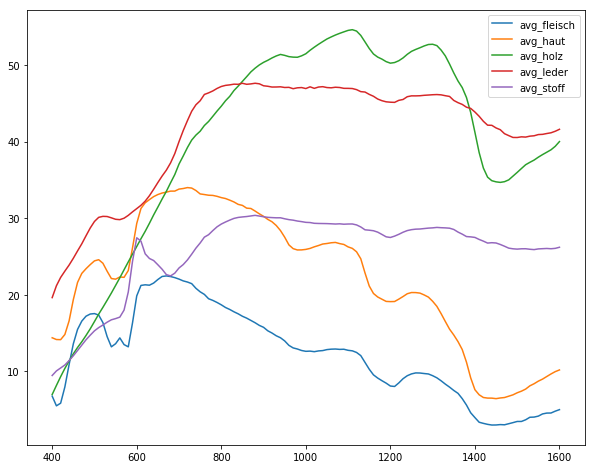

In [3]:
avg_fleisch = np.array(fleisch.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_leder = np.array(leder.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_holz = np.array(holz.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_stoff = np.array(stoff.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_haut = np.array(haut.iloc[:,1:].mean(axis = 1))[np.newaxis].T

wavelength = np.array(fleisch['nm'])[np.newaxis].T
plt.figure(figsize=[10,8])
plt.plot(wavelength,avg_fleisch,label='avg_fleisch')
plt.plot(wavelength,avg_haut,label='avg_haut')
plt.plot(wavelength,avg_holz,label='avg_holz')
plt.plot(wavelength,avg_leder,label='avg_leder')
plt.plot(wavelength,avg_stoff,label='avg_stoff')

plt.legend()

In [8]:
from sklearn.decomposition import PCA

def dataCleanup(data):

    gross_avg = np.array(data.iloc[:,1:].mean(axis = 1))

    # print('average of the combined dataset={}'.format(gross_avg.shape))

    mean_removed_data = data.subtract(gross_avg, axis = 0)
    
#     mean_removed_data.index

    pca = PCA(.98)

    pca.fit(mean_removed_data)

    cleaned_data = pca.transform(mean_removed_data)    
    
    print('number of components selected to maintain 98% of variance = {}'.format(pca.n_components_))
    print('the variance ratio for each component = {}'.format(pca.explained_variance_ratio_))

    cleaned_data = pd.DataFrame(index = mean_removed_data.index, data = cleaned_data)
    return cleaned_data


In [9]:
# print ('fleisch shape={}\n haut shape={}\n holz shape={}\n leder shape={}\n stoff shape={}'\
# .format(fleisch.shape, haut.shape, holz.shape, leder.shape, stoff.shape))

res = fleisch.set_index('nm').combine_first(haut.set_index('nm')).combine_first(holz.set_index('nm'))\
.combine_first(leder.set_index('nm')).combine_first(stoff.set_index('nm'))

In [10]:
spectral_dataset = dataCleanup(res)
spectral_dataset

number of components selected to maintain 98% of variance = 5
the variance ratio for each component = [0.76567103 0.15050562 0.0370002  0.02152921 0.00879647]


,0,1,2,3,4
nm,,,,,
400,185.699407,87.685158,50.282669,8.083986,50.185456
410,173.874345,83.460023,41.816612,5.237924,45.011106
420,172.254490,77.037128,38.900084,3.526808,35.849235
430,181.143976,68.970574,41.259788,2.132414,23.556167
440,194.863853,59.842009,44.192959,0.433998,11.686154
450,206.577456,51.698114,45.118541,-1.903355,4.008754
460,212.624019,45.123216,44.006996,-5.345205,0.447763
470,214.032694,39.944518,41.456707,-8.892089,-1.395817
480,212.657487,34.951849,37.761967,-12.471680,-3.915376


In [7]:
average_data = [avg_fleisch,avg_haut,avg_holz,avg_leder,avg_stoff]
toy_dataset = np.empty([0,2])

labels = []

for idx, val in enumerate(average_data):
    dataset = np.hstack((wavelength,val))
    toy_dataset = np.vstack((toy_dataset, dataset))
    if idx > 1:
        labels.append(np.zeros(np.size(val)))
    else:
        labels.append(np.ones(np.size(val)))
    
labels = np.array(labels)
labels = labels.reshape(605,1)
print(toy_dataset.shape)
print(np.sum(labels))

(605, 2)
242.0


In [20]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold


# kfold_splits = 5

# skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

# # Loop through the indices the split() method returns
# for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
#     print "Training on fold " + str(index+1) + "/10..."
#     # Generate batches from indices
#     xtrain, xval = X[train_indices], X[val_indices]
#     ytrain, yval = y[train_indices], y[val_indices]


In [21]:
mlp = Sequential()
mlp.add(Dense(units = 4,input_dim = 4, init = 'uniform'))
mlp.add(Dense(units = 5, activation='relu'))
mlp.add(Dense(units = 2, activation ='sigmoid'))

In [22]:
mlp.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.SGD(lr=0.06, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [11]:
from keras.utils import to_categorical
# labels = to_categorical(labels)

# mlp.fit(spectral_dataset, labels, epochs = 8, batch_size = 201)

we need to work on getting the target labels for the cleaned data